In [46]:
# !pip install tensorflow-datasets
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_desc = 'discriminator_org_best_using_cnn_classification'

noise_file = np.load('./data/CIFAR-10_human_ordered.npy', allow_pickle=True)
clean_label = noise_file.item().get('clean_label')
worst_label = noise_file.item().get('worse_label')
aggre_label = noise_file.item().get('aggre_label')
random_label1 = noise_file.item().get('random_label1')
random_label2 = noise_file.item().get('random_label2')
random_label3 = noise_file.item().get('random_label3')

classess_name = {0: 'airplane',
 1:'automobile',
 2:'bird',
 3:'cat',
 4:'deer',
 5:'dog',
 6:'frog',
 7:'horse',
 8:'ship',
 9:'truck'}

batch_size=128
input_size = 3*32*32
output_size = 10
torch.manual_seed(43)
val_size = 5000
train_size = 50000 - val_size

# The noisy label matches with following tensorflow dataloader
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True, batch_size = -1)
# train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)
train_images, train_labels = tfds.as_numpy(train_ds) 
test_images, test_labels = tfds.as_numpy(test_ds) 
# You may want to replace train_labels by CIFAR-N noisy label sets
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)



# # building the input vector from the 32x32 pixels
X_train = train_images.reshape(train_images.shape[0], 32, 32, 3)
X_test = test_images.reshape(test_images.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255
print('clean_label -;', len(clean_label))
print('random_label2 -;', len(random_label2))
print('worst_label -;', len(worst_label))
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding train_labels: ", train_labels.shape)
print("Shape before one-hot encoding X_train: ", X_train.shape)
Y_train = np_utils.to_categorical(train_labels, n_classes)
Y_test = np_utils.to_categorical(test_labels, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)



(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)
clean_label -; 50000
random_label2 -; 50000
worst_label -; 50000
Shape before one-hot encoding train_labels:  (50000,)
Shape before one-hot encoding X_train:  (50000, 32, 32, 3)
Shape after one-hot encoding:  (50000, 10)


In [40]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, ZeroPadding2D
from keras.utils import np_utils
# building a linear stack of layers with the sequential model
cnn_classifier = Sequential()

# convolutional layer
cnn_classifier.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))

# convolutional layer
cnn_classifier.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
cnn_classifier.add(MaxPool2D(pool_size=(2,2)))
cnn_classifier.add(Dropout(0.25))

cnn_classifier.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
cnn_classifier.add(MaxPool2D(pool_size=(2,2)))
cnn_classifier.add(Dropout(0.25))

# flatten output of conv
cnn_classifier.add(Flatten())

# hidden layer
cnn_classifier.add(Dense(500, activation='relu'))
cnn_classifier.add(Dropout(0.4))
cnn_classifier.add(Dense(250, activation='relu'))
cnn_classifier.add(Dropout(0.3))
# output layer
cnn_classifier.add(Dense(10, activation='softmax'))

# compiling the sequential model
cnn_classifier.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
# cnn_classifier.fit(X_train, Y_train, batch_size=128, epochs=75, validation_data=(X_test, Y_test))
cnn_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 50)        1400      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 75)        33825     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 75)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 75)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 125)       84500     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 125)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 125)         0

In [ ]:
from keras.models import load_model
from pickle import dump, load

#creates a HDF5 file 'cnn_classifier.h5'
cnn_classifier = load_model('cnn_classifier_75ep.h5')  
cnn_classifier.summary()

(1, 32, 32, 3)
LBL:  [1, 9, 8, 0, 3]
LBL_names:  ['automobile', 'truck', 'ship', 'airplane', 'cat']


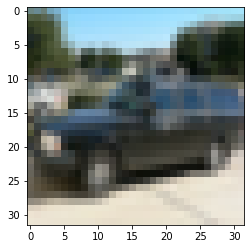

In [31]:
ind = 98
img = X_test[ind].reshape(1, X_test[0].shape[0], X_test[0].shape[1], X_test[0].shape[2])

plt.imshow(X_test[ind])
print(img.shape)
probability = cnn_classifier.predict(img)
pred_org = list(probability[0])
preds = sorted(pred_org, reverse=True)[:5]

labels = [pred_org.index(pred) for pred in preds]
labels_names = [classess_name[i] for i in labels]
print("LBL: ", labels)
print("LBL_names: ", labels_names)

In [40]:
preds_cnn = [cnn_classifier.predict(img.reshape(1, img.shape[0], img.shape[1], img.shape[2])) for img in X_train]

In [50]:
import pickle
with open('cnn_predictions.pickle', 'wb') as handle:
    pickle.dump(preds_cnn, handle)

In [21]:
import pickle
with open('cnn_predictions.pickle', 'rb') as handle:
    b = pickle.load(handle)

7

In [23]:
import pickle
with open('cnn_final_labels.pickle', 'wb') as handle:
    pickle.dump(bb, handle)


In [47]:
import pickle
with open('cnn_final_labels.pickle', 'rb') as handle:
    b = pickle.load(handle)

TrainLabel: frog  CleanLabel: frog  random_label1: cat  worst_label: cat


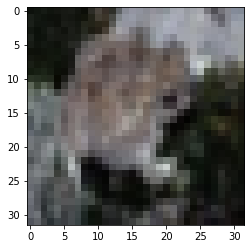

In [33]:
ind=9
plt.imshow(X_train[ind])

def plot_labels(im_ind):
    print("TrainLabel:", classess_name[list(Y_train[im_ind]).index(1)], " CleanLabel:", classess_name[clean_label[im_ind]], " random_label1:", classess_name[random_label1[im_ind]], " worst_label:", classess_name[worst_label[im_ind]])

plot_labels(ind)

In [105]:
from keras.models import Sequential
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten, Embedding, Input, InputLayer
from keras.utils import np_utils

# building a linear stack of layers with the sequential model
discriminator2 = Sequential()
categorical_input = Input(shape=(1), name='categorical_lbl')
dense01 = Dense(8, activation='relu')(categorical_input)

inputL = Input(shape=(32, 32, 3), name='image')
conv1 = Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu')(inputL)
maxP1 = MaxPool2D(pool_size=2)(conv1)
conv2 = Conv2D(filters=64, kernel_size=4,  padding='same', activation='relu')(maxP1)
maxP2 = MaxPool2D(pool_size=2)(conv2)
conv3 = Conv2D(filters=64, kernel_size=4,  padding='same', activation='relu')(maxP2)
maxP3 = MaxPool2D(pool_size=2)(conv3)
conv4 = Conv2D(filters=128, kernel_size=3,  padding='same', activation='relu')(maxP3)
maxP4 = MaxPool2D(pool_size=2)(conv4)
conv5 = Conv2D(filters=128, kernel_size=2,  padding='same', activation='relu')(maxP4)
maxP5 = MaxPool2D(pool_size=2)(conv5)
do1 = Dropout(0.25)(maxP5)
flt = Flatten()(do1)
dense1 = Dense(128, activation='relu')(flt)
flatten2 = Flatten()(dense1)
merge = concatenate([dense01, flatten2])


dense2 = Dense(64, activation='relu')(merge)
dense3 = Dense(32, activation='relu')(dense2)
output = Dense(1, activation='sigmoid')(dense3)

discriminator2 = Model(inputs=[inputL, categorical_input], outputs=output)
# compiling the sequential model
discriminator2.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
discriminator2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 32)   896         image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 16, 16, 64)   32832       max_pooling2d_12[0][0]           
____________________________________________________________________________________________

In [48]:
New_Train_Data_i = []
New_Train_Data_l = []
New_Train_Label = []

for i, data in enumerate(X_train):
    img_data = X_train[i]
    x_org = tf.stack(img_data)
    y_clean =   b[i]
    
    past_noises = []
    for noise in ['worse_label','aggre_label','random_label1','random_label2','random_label3']:
        noise_label = noise_file.item().get(noise)[i]
        if y_clean != noise_label and noise_label not in past_noises:
            x = tf.stack(img_data)
            y = noise_label
            # balance with-:
            New_Train_Label.append(0)
            New_Train_Data_i.append(x_org)
            New_Train_Data_l.append(y_clean)
            past_noises.append(noise_label)
            New_Train_Label.append(1)
            New_Train_Data_i.append(x)
            New_Train_Data_l.append(y)


print("DONE!")

DONE!


In [49]:
len(New_Train_Label)

47872

In [83]:
def create_discrimination_dataset(X_train, Y_train, X_test, Y_test):
    New_Train_Data_i = []
    New_Train_Data_l = []
    New_Train_Label = []

    with open('cnn_final_labels.pickle', 'rb') as handle:
        cnn_labels = pickle.load(handle)
    ii = 0
    for i, data in enumerate(X_train):
        img_data = X_train[i]
        x_org = tf.stack(img_data)
        y_clean =  cnn_labels[i] 
        past_noises = []
        
        for noise in ['worse_label', 'aggre_label', 'random_label1', 'random_label2', 'random_label3']:
            noise_label = noise_file.item().get(noise)[i]
            
            if y_clean != noise_label:
                ii = ii +1
#                 print(y_clean, noise_label)
            if y_clean != noise_label and noise_label not in past_noises:
                x = tf.stack(img_data)
                y = noise_label
                # balance with-:
                New_Train_Label.append(0)
                New_Train_Data_i.append(x_org)
                New_Train_Data_l.append(y_clean)
                past_noises.append(noise_label)
                New_Train_Label.append(1)
                New_Train_Data_i.append(x)
                New_Train_Data_l.append(y)
    print(ii)
    print(len(New_Train_Label))
    print("Balance of labels : ", sum(New_Train_Label) / len(New_Train_Label))
    TEST_SIZE = int(len(New_Train_Label) / 10)
    print("TEST_SIZE: ", TEST_SIZE)
    New_Train_Data_i = New_Train_Data_i[0:len(New_Train_Data_i) - TEST_SIZE]
    New_Train_Data_l = New_Train_Data_l[0:len(New_Train_Data_l) - TEST_SIZE]
    New_Train_Label = New_Train_Label[0:len(New_Train_Label) - TEST_SIZE]

    New_Test_Data_i = New_Train_Data_i[(len(New_Train_Data_i) - TEST_SIZE):]
    New_Test_Data_l = New_Train_Data_l[(len(New_Train_Data_l) - TEST_SIZE):]
    New_Test_Label = New_Train_Label[(len(New_Train_Label) - TEST_SIZE):]

    x_TrI = np.stack(New_Train_Data_i)
    x_TrI = np.array(x_TrI)
    x_TeI = np.stack(New_Test_Data_i)
    x_TeI = np.array(x_TeI)

    x_TrL = np.stack(New_Train_Data_l).reshape(len(New_Train_Data_l), 1)
    x_TrL = np.array(x_TrL)
    x_TeL = np.stack(New_Test_Data_l).reshape(len(New_Test_Data_l), 1)
    x_TeL = np.array(x_TeL)


    New_Train_Label = np.array(New_Train_Label)
    New_Test_Label = np.array(New_Test_Label)
    print("DONE!")

    return x_TrI, x_TrL, New_Train_Label, x_TeI, x_TeL, New_Test_Label

In [84]:
x_TrI, x_TrL, New_Train_Label, x_TeI, x_TeL, New_Test_Label = create_discrimination_dataset(X_train, Y_train, X_test, Y_test)

51124
47872
Balance of labels :  0.5
TEST_SIZE:  4787
DONE!


In [85]:
len(New_Train_Label)

43085

In [86]:
print("Balance of labels : ",sum(New_Train_Label)/len(New_Train_Label))

Balance of labels :  0.49998839503307413


In [39]:
TEST_SIZE = int(len(New_Train_Label) / 10)
print("TEST_SIZE: ", TEST_SIZE)
New_Train_Data_i = New_Train_Data_i[0:len(New_Train_Data_i) - TEST_SIZE]
New_Train_Data_l = New_Train_Data_l[0:len(New_Train_Data_l) - TEST_SIZE]
New_Train_Label = New_Train_Label[0:len(New_Train_Label) - TEST_SIZE]

New_Test_Data_i = New_Train_Data_i[(len(New_Train_Data_i) - TEST_SIZE):]
New_Test_Data_l = New_Train_Data_l[(len(New_Train_Data_l) - TEST_SIZE):]
New_Test_Label = New_Train_Label[(len(New_Train_Label) - TEST_SIZE):]

TEST_SIZE:  4787


In [40]:
x_TrI= np.stack(New_Train_Data_i)
x_TrI = np.array(x_TrI)
print("DONE!")
x_TrI.shape

DONE!


(43085, 32, 32, 3)

In [41]:
x_TrL = np.stack(New_Train_Data_l).reshape(len(New_Train_Data_l), 1)
x_TrL = np.array(x_TrL)
print("DONE!")
x_TrL.shape

DONE!


(43085, 1)

In [42]:
x_TeI=np.stack(New_Test_Data_i)
x_TeI = np.array(x_TeI)
print("DONE!")
x_TeI.shape

DONE!


(4787, 32, 32, 3)

In [43]:
x_TeL = np.stack(New_Test_Data_l).reshape(len(New_Test_Data_l), 1)
x_TeL = np.array(x_TeL)
print("DONE!")

DONE!


In [44]:
# x_TrI, x_TrL=[np.stack(New_Train_Data_i),np.stack(New_Train_Data_l).reshape(len(New_Train_Data_l), 1)]
# x_TeI, x_TeL=[np.stack(New_Test_Data_i),np.stack(New_Test_Data_l).reshape(len(New_Test_Data_l), 1)]

New_Train_Label = np.array(New_Train_Label)
New_Test_Label = np.array(New_Test_Label)
print("DONE!")

DONE!


In [47]:
import os
# training the model for 100 epochs
early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        mode='auto',
    )

if not os.path.exists("saved_models"):
    os.mkdir("saved_models")
cache = f'saved_models/{model_desc}.ckpt'
model_desc

'discriminator_org_best_using_cnn_classification'

In [49]:
checkpoint = ModelCheckpoint(cache,
                                 monitor='val_accuracy',
                                 verbose=True,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='max')

history = discriminator2.fit([x_TrI, x_TrL], New_Train_Label, batch_size=128,
                        epochs=100,
                        callbacks=[checkpoint, early_stop],
                        validation_data=([x_TeI, x_TeL], New_Test_Label),
                        verbose=True)
    


Epoch 1/100
337/337 [==============================] - 26s 76ms/step - loss: 0.6902 - accuracy: 0.5295 - val_loss: 0.6861 - val_accuracy: 0.5377

Epoch 00001: val_accuracy improved from -inf to 0.53771, saving model to saved_models/discriminator_org_best_using_cnn_classification.ckpt
Epoch 2/100
337/337 [==============================] - 25s 75ms/step - loss: 0.6794 - accuracy: 0.5560 - val_loss: 0.6654 - val_accuracy: 0.5860

Epoch 00002: val_accuracy improved from 0.53771 to 0.58596, saving model to saved_models/discriminator_org_best_using_cnn_classification.ckpt
Epoch 3/100
337/337 [==============================] - 25s 73ms/step - loss: 0.6636 - accuracy: 0.5855 - val_loss: 0.6518 - val_accuracy: 0.6146

Epoch 00003: val_accuracy improved from 0.58596 to 0.61458, saving model to saved_models/discriminator_org_best_using_cnn_classification.ckpt
Epoch 4/100
337/337 [==============================] - 24s 71ms/step - loss: 0.6483 - accuracy: 0.6097 - val_loss: 0.6411 - val_accuracy: 0

In [50]:
discriminator2.save(f'{model_desc}.h5')
history

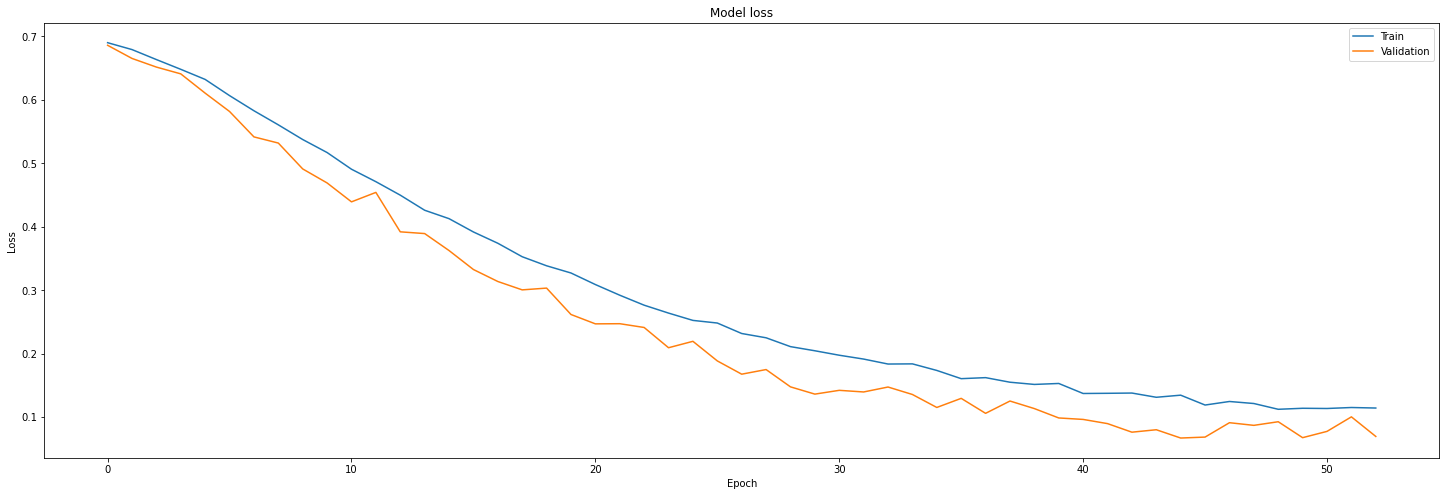

In [52]:
from matplotlib.pyplot import figure
def plot_loss(history,train_loss_path='loss',val_loss_path='val_loss'):
    figure(figsize=(25, 8))
    plt.plot(train_loss_path)
    plt.plot(val_loss_path)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
plot_loss(history.history, history.history['loss'], history.history['val_loss'])

In [53]:
discriminator2.predict([x_TeI,x_TeL])

array([[2.0745188e-02],
       [9.7163689e-01],
       [1.7199904e-02],
       ...,
       [5.1108003e-04],
       [9.9998653e-01],
       [1.7689914e-02]], dtype=float32)

In [66]:
ind = 475
s_TrI1= np.stack(x_TrI[ind:ind+2])
s_TrI2 = np.array(x_TrL[ind:ind+2])


s_TrL = np.array(New_Train_Label[ind:ind+2])
# print(s_TrI1)
print(s_TrI2)
print(s_TrL)
discriminator2.predict([s_TrI1,s_TrI2])

[[1]
 [9]]
[1 0]


array([[9.9968231e-01],
       [5.9115887e-04]], dtype=float32)

1 is noise!!!
____________
automobile 1
Lier? :  True  Trut is -  1
truck 0
Lier? :  False  Trut is -  0


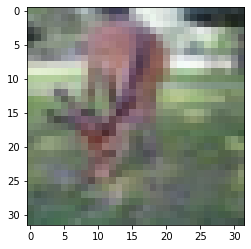

In [67]:
print("1 is noise!!!")
print("____________")
plt.imshow(s_TrI1[0])
print(classess_name[int(s_TrI2[0])], s_TrL[0])
print("Lier? : ",discriminator2.predict([s_TrI1,s_TrI2])[0][0] > 0.5, " Trut is - " ,s_TrL[0])
# print("____________")
print(classess_name[int(s_TrI2[1])], s_TrL[1])
print("Lier? : ",discriminator2.predict([s_TrI1,s_TrI2])[1][0] > 0.5, " Trut is - " ,s_TrL[1])

In [2]:
from keras.models import load_model
from pickle import dump, load

#creates a HDF5 file 'cnn_classifier.h5'
discriminator = load_model('discriminator_org_best_using_cnn_classification.h5')  
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 32)   896         image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 16, 16, 64)   32832       max_pooling2d_7[0][0]            
____________________________________________________________________________________________

____________
____________
____________
              precision    recall  f1-score   support

  good label       0.26      0.67      0.37     10000
    Outlier!       0.96      0.79      0.86     90000

    accuracy                           0.78    100000
   macro avg       0.61      0.73      0.62    100000
weighted avg       0.89      0.78      0.81    100000



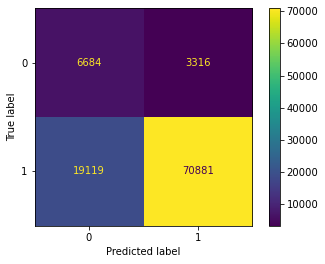

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_roc_curve
from keras.models import load_model
from pickle import dump, load


discriminator = load_model('discriminator_org_best_using_cnn_classification.h5')  
Y_test = [list(p).index(max(p)) for p in Y_test]

test_Data_i = []
test_Data_l = []
test_Label = []

for i, data in enumerate(X_test):
    x_org = tf.stack(data)
    y_clean =  Y_test[i]
    test_Data_i.append(x_org)
    test_Data_l.append(y_clean)
    test_Label.append(0)
    for noise_l in range(0,10):
        if noise_l != y_clean:
            # balance with-:  
            test_Label.append(1)
            test_Data_i.append(x_org)
            test_Data_l.append(noise_l)

print("____________")
test_Data_i= np.stack(test_Data_i)
test_Data_i = np.array(test_Data_i)

test_Data_l = np.stack(test_Data_l).reshape(len(test_Data_l), 1)
test_Data_l = np.array(test_Data_l)
test_Label = np.array(test_Label)
print("____________")
new_preds = discriminator.predict([test_Data_i,test_Data_l])
new_preds = [o[0] for o in new_preds]
new_preds = [1 if i > 0.5 else 0 for i in new_preds]
print("____________")
labels = [0, 1]
cm = confusion_matrix(list(test_Label), new_preds, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

target_names = ['good label', 'Outlier!']
print(classification_report(test_Label, new_preds, target_names=target_names))

In [3]:
sum(new_preds)/len(new_preds)

0.74197